In [1]:
import numpy as np
import sympy as sp
import matplotlib as mpl 
import matplotlib.pyplot as plt
import pandas as pd

## Provided Code

In [2]:
def f_K(pstar, qK):
  # First extract density, velocity, and pressure from q
    rhoK = qK[0]; pK = (gamma-1)*(qK[2]-qK[1]**2/qK[0]/2)
    if pstar < pK: # Rarefaction wave
    # Calculate speed of sound
        cK = np.sqrt(gamma * pK / rhoK)
    # Return fK
        return 2 * cK / (gamma - 1) * ((pstar / pK)**((gamma - 1)/(2 * gamma)) - 1)
    else: # Shock wave
    # Calculate A and B
        AK = 2 / (rhoK * (gamma + 1))
        BK = (gamma - 1) / (gamma + 1) * pK
    # Return fK
        return (pstar - pK) * np.sqrt(AK / (BK + pstar))

def f(pstar, qL, qR):
    return qR[1]/qR[0] - qL[1]/qL[0] + f_K(pstar, qL) + f_K(pstar, qR)
        
def pstar_bisection(qL, qR):
    # Maximum number of iterations
    itmax = 100
    # Compute initial bounds
    pL = (gamma - 1) * (qL[2] - qL[1]**2/qL[0]/2)
    pR = (gamma - 1) * (qR[2] - qR[1]**2/qR[0]/2)
    a = 0.9 * (pL + pR)/2
    b = 1.1 * (pL + pR)/2
    it = 0
    # Make sure f(a) is negative
    while f(a, qL, qR) > 0 and it < itmax: 
        a /= 2; it += 1
    it = 0
    # Make sure f(b) is positive
    while f(b, qL, qR) < 0 and it < itmax:  
        b *= 2; it += 1
    # Bisection algorithm
    it = 0; epsilon = 1e-6
    pstar = (a + b) / 2
    fpstar = f(pstar, qL, qR)
    while np.abs(fpstar) > epsilon and (b - a)/2 > epsilon and it < itmax:
        pstar = (a + b) / 2
        fpstar = f(pstar, qL, qR)
        if fpstar > 0: b = pstar
        else: a = pstar
        it += 1
    # Return (approximate) root
    return pstar

def ustar_avg(pstar, qL, qR):
    return 1/2 * (qL[1]/qL[0] + qR[1]/qR[0] + f_K(pstar, qR) - f_K(pstar, qL))

def rho_K(pstar, qK):
    # First extract density, velocity, and pressure from q
    rhoK = qK[0]; pK = (gamma-1)*(qK[2]-qK[1]**2/qK[0]/2)
    if pstar < pK: # Rarefaction wave
        return rhoK * (pstar / pK)**(1 / gamma)
    else: # Shock wave
        return rhoK * ((gamma - 1) * pK + (gamma + 1) * pstar) / ((gamma + 1) * pK + (gamma - 1) * pstar)

def RiemannSolutionWithPstarUstar(qL, qR, pstar, ustar, xi):
  # First extract density, velocity, and pressure from q
    rhoL = qL[0]; rhouL = qL[1]; rhoEL = qL[2]
    rhoR = qR[0]; rhouR = qR[1]; rhoER = qR[2]
    uL = rhouL/rhoL
    uR = rhouR/rhoR
    pL = (gamma-1)*(rhoEL-rhoL*uL**2/2)
    pR = (gamma-1)*(rhoER-rhoR*uR**2/2)

  # Considering the case of left/right rarefaction or shock wave, return solution for xi
    if xi < ustar:    # To the left of the contact discontinuity
        rhoLstar = rho_K(pstar, qL)
        cL = np.sqrt(gamma * pL / rhoL)
        if pstar < pL:  # Left rarefaction wave
            cLstar = np.sqrt(gamma * pstar / rhoLstar)
            if xi < uL - cL:
                return qL
            elif xi < ustar - cLstar:
                rhoLfan = rhoL * (2 / (gamma + 1) + (gamma - 1) / (gamma + 1) * (uL - xi) / cL)**(2 / (gamma - 1))
                uLfan = (gamma - 1) / (gamma + 1) * (uL + 2 * (xi + cL) / (gamma - 1))
                pLfan = pL * (2 / (gamma + 1) + (gamma - 1) / (gamma + 1) * (uL - xi) / cL)**(2 * gamma / (gamma - 1))
                return np.array([rhoLfan, rhoLfan*uLfan, pLfan/(gamma-1)+rhoLfan*uLfan**2/2])
            else:
                return np.array([rhoLstar, rhoLstar*ustar, pstar/(gamma-1)+rhoLstar*ustar**2/2])
        else:           # Left shock wave
            SL = uL - cL * np.sqrt((gamma + 1) / (2 * gamma) * pstar / pL + (gamma - 1) / (2 * gamma))
            if xi < SL:
                return qL
            else:
                return np.array([rhoLstar, rhoLstar*ustar, pstar/(gamma-1)+rhoLstar*ustar**2/2])
    else:             # To the right of the contact discontinuity
        rhoRstar = rho_K(pstar, qR)
        cR = np.sqrt(gamma * pR / rhoR)
        if pstar < pR:  # Right rarefaction wave
            cRstar = np.sqrt(gamma * pstar / rhoRstar)
            if xi < ustar + cRstar:
                return np.array([rhoRstar, rhoRstar*ustar, pstar/(gamma-1)+rhoRstar*ustar**2/2])
            elif xi < uR + cR:
                rhoRfan = rhoR * (2 / (gamma + 1) - (gamma - 1) / (gamma + 1) * (uR - xi) / cR)**(2 / (gamma - 1))
                uRfan = (gamma - 1) / (gamma + 1) * (uR + 2 * (xi - cR) / (gamma - 1))
                pRfan = pR * (2 / (gamma + 1) - (gamma - 1) / (gamma + 1) * (uR - xi) / cR)**(2 * gamma / (gamma - 1))
                return np.array([rhoRfan, rhoRfan*uRfan, pRfan/(gamma-1)+rhoRfan*uRfan**2/2])
            else:
                return qR
        else:           # Right shock wave
            SR = uR + cR * np.sqrt((gamma + 1) / (2 * gamma) * pstar / pR + (gamma - 1) / (2 * gamma))
            if xi < SR:
                return np.array([rhoRstar, rhoRstar*ustar, pstar/(gamma-1)+rhoRstar*ustar**2/2])
            else:
                return qR
            
def RiemannSolver(qL, qR, xdividedbyt):
    pstar = pstar_bisection(qL, qR)
    ustar = ustar_avg(pstar, qL, qR)
    return RiemannSolutionWithPstarUstar(qL, qR, pstar, ustar, xdividedbyt)

## Problem 1

In [3]:
def initialize_shock_tube(N_x, L_1, L_4, p1, T1, u1, p4, T4, u4, gamma, R):
    x = np.linspace(0, L_1+L_4, N_x +2) #total length is L_1+L_4
    dx = x[1] - x[0] #grid spacing

    #state vectors
    rho = np.zeros(N_x +2)
    u = np.zeros(N_x +2)
    p = np.zeros(N_x +2)
    E = np.zeros(N_x +2)

    rho1 = p1 / (R * T1)
    rho4 = p4 / (R * T4)
    E1 = p1 / ((gamma - 1) * rho1) + 0.5 * u1**2
    E4 = p4 / ((gamma - 1) * rho4) + 0.5 * u4**2

    for i in range(N_x + 2):
        if x[i] < L_4:
            rho[i] = rho4
            u[i] = u4
            p[i] = p4
            E[i] = E4
            #E[i] = E4 / rho4
        else:
            rho[i] = rho1
            u[i] = u1
            p[i] = p1
            E[i] = E1
            #E[i] = E1 / rho1

    return x, rho, u, p, E, dx

def update_boundaries(rho, u, p, E, N_x, boundary_type='solid-wall'):
    if boundary_type == 'solid-wall':
        #u=0 at the wall, and gradients of rho and E are zero
        u[0] = -u[1]
        u[-1] = -u[-2]
        
        rho[0] = rho[1]
        rho[-1] = rho[-2]
        #E[0] = p[1] / (gamma - 1)
        #E[-1] = p[-2] / (gamma - 1)
        E[0] = E[1]
        E[-1] = E[-2]

        
        #p[0] = (gamma - 1) * (E[0] - 0.5 * rho[0] * u[0]**2)
        #p[-1] = (gamma - 1) * (E[-1] - 0.5 * rho[-1] * u[-1]**2)
        
    elif boundary_type == 'far-field':
        #gradients of all quantities are set to zero
        rho[0] = rho[1]
        rho[-1] = rho[-2]
        u[0] = u[1]
        u[-1] = u[-2]
        p[0] = p[1]
        p[-1] = p[-2]
        E[0] = E[1]
        E[-1] = E[-2]
        
        #p[0] = (gamma - 1) * (E[0] - 0.5 * rho[0] * u[0]**2)
        #p[-1] = (gamma - 1) * (E[-1] - 0.5 * rho[-1] * u[-1]**2)
        
        
        
    return rho, u, p, E
    
def godunov(N_x, dx, dt, rho, u, p, E, gamma, boundary_type):
    #boundary conditions before computing fluxes
    rho, u, p, E = update_boundaries(rho, u, p, E, N_x + 2, boundary_type)
    
    flux1 = np.zeros(N_x + 2)
    flux2 = np.zeros(N_x + 2)
    flux3 = np.zeros(N_x + 2)
    rho_s = np.zeros(N_x + 2)
    u_s = np.zeros(N_x + 2)
    p_s = np.zeros(N_x + 2)

    #fluxes at each cell interface
    for i in range(1, N_x + 2):
        qL = np.array([rho[i-1], rho[i-1] * u[i-1], rho[i-1] * E[i-1]])
        qR = np.array([rho[i], rho[i] * u[i], rho[i] *E[i]])
        pstar = pstar_bisection(qL, qR)
        ustar = ustar_avg(pstar, qL, qR)
        #'xi' = 0 because we want the flux at the interface (which is at x/t = 0)
        flux = RiemannSolutionWithPstarUstar(qL, qR, pstar, ustar, 0)
        
        rho_s[i-1] = flux[0]   ##rho
        u_s[i-1] = flux[1] / flux[0]   ##u
        p_s[i-1] = (gamma - 1) * (flux[2] - 0.5 * flux[1]**2 / flux[0])    ##p
        
        flux1[i-1] = rho_s[i-1] * u_s[i-1]
        flux2[i-1] = rho_s[i-1] * u_s[i-1]**2 + p_s[i-1]
        flux3[i-1] = (flux[2] + p_s[i-1]) * u_s[i-1]
        
    old_rho = rho.copy()
    for i in range(1, N_x + 1):
        #update density
        rho[i] -= dt/dx * (flux1[i] - flux1[i-1])
        
        #update momentum using old density values
        momentum = old_rho[i] * u[i] - dt/dx * (flux2[i] - flux2[i-1])
        # use updated rho[i] because we've already updated density in the first step
        u[i] = momentum / rho[i] 
    
        #update total energy using the old density values
        energy_density = old_rho[i] * E[i] - dt/dx * (flux3[i] - flux3[i-1])
        #use updated rho[i] for the same reason
        E[i] = energy_density / rho[i]
        
        p[i] = (gamma - 1) * (energy_density - 0.5 * momentum**2 / rho[i])
        #p[i] = (E[i] - 0.5 * rho[i] * u[i]**2) * (gamma - 1)

    return rho, u, p, E

def solve_shock_tube(L1, L4, gamma, R, p1, T1, u1, p4, T4, u4, Nx, t_final, dt, boundary_type):
    x, rho, u, p, E, dx = initialize_shock_tube(Nx, L1, L4, p1, T1, u1, p4, T4, u4, gamma, R)

    rho_history = np.zeros((Nx + 2, int(t_final / dt) +1 ))
    u_history = np.zeros((Nx + 2, int(t_final / dt) +1 ))
    p_history = np.zeros((Nx + 2, int(t_final / dt)  +1))

    #initial state
    rho_history[:, 0] = rho
    u_history[:, 0] = u
    p_history[:, 0] = p

    #Godunov's method
    for timestep in range(1, int(t_final / dt) +1):
        rho, u, p, E = godunov(Nx, dx, dt, rho, u, p, E, gamma, boundary_type)

        #state at the current timestep
        rho_history[:, timestep] = rho
        u_history[:, timestep] = u
        p_history[:, timestep] = p

    return rho_history, u_history, p_history

## Problem 2

In [4]:
toro1 = pd.read_excel('test1Toro.xlsx')
toro2 = pd.read_excel('test2Toro.xlsx')

### Test 1

In [5]:
R = 287.0 
gamma = 1.4  

# Test 1 initial conditions
rhoL = 0.125 #1.0
uL = 0.0
pL = 0.1 #1.0
rhoR = 1 #0.125
uR = 0.0
pR = 1 #0.1
TL = pL / (rhoL * R)
TR = pR / (rhoR * R)

L_toro_list = [(1.0, 0.0, 1.0)]
R_toro_list = [(0.125, 0.0, 0.1)]
tfinal_toro_list = [0.25]

t_final = 0.25
Nx = 501 # Number of grid points
dx = 1/Nx #0.01 #grid spacing
dt = 6.25e-4 #0.00005 #time step size
L1 = 0.5
L4 = 0.5
#t_final = 150 * dt

rho_history, u_history, p_history = solve_shock_tube(
    L1=L1, L4=L4,
    gamma=gamma, R=R,
    p1=pL, T1=TL, u1=uL,
    p4=pR, T4=TR, u4=uR,
    Nx=Nx, t_final=t_final, dt=dt,
    boundary_type='far-field'  # use far-field conditions
)

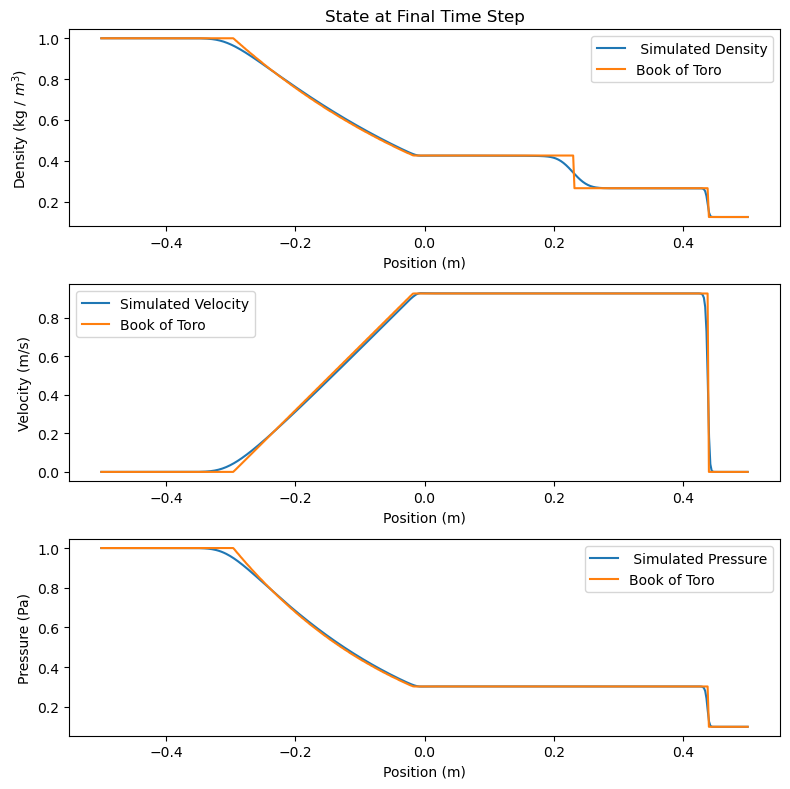

In [6]:
time_index = -1

x_positions = np.linspace(-L4, L1, Nx + 2)


plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)  #density
plt.plot(x_positions, rho_history[:, time_index], label=' Simulated Density')
plt.plot(toro1.iloc[:,0], toro1.iloc[:,3], label = "Book of Toro")
plt.title('State at Final Time Step')
plt.xlabel('Position (m)')
plt.ylabel('Density (kg / ' + r'$m^3$' + ')')
plt.legend()

# Plot velocity
plt.subplot(3, 1, 2)  #velocity
plt.plot(x_positions, u_history[:, time_index], label='Simulated Velocity')
plt.plot(toro1.iloc[:,0], toro1.iloc[:,4], label = "Book of Toro")
plt.xlabel('Position (m)')
plt.ylabel('Velocity (m/s)')
plt.legend()

# Plot pressure
plt.subplot(3, 1, 3)  #pressure
plt.plot(x_positions, p_history[:, time_index], label=' Simulated Pressure')
plt.plot(toro1.iloc[:,0], toro1.iloc[:,5], label = "Book of Toro")
plt.xlabel('Position (m)')
plt.ylabel('Pressure (Pa)')
plt.legend()

plt.tight_layout()
plt.show()

### Test 2

In [7]:
R = 287.0
gamma = 1.4 

# Test 2 initial conditions
rhoL = 1.0  
uL = 2.0  
pL = 0.4 
rhoR = 1.0
uR = -2.0  
pR = 0.4  

TL = pL / (rhoL * R)
TR = pR / (rhoR * R)

L_toro_list = [(1.0, -2.0, 0.4)] 
R_toro_list = [(1.0, 2.0, 0.4)]  
tfinal_toro_list = [0.15]

# Simulation parameters for Test 1
t_final = 0.15  # s
Nx = 501  # Number of grid points
dx = 1/Nx  # m, grid spacing
dt = 6.25e-4  # s, time step size
L1 = 0.5
L4 = 0.5


rho_history, u_history, p_history = solve_shock_tube(
    L1=L1, L4=L4,
    gamma=gamma, R=R,
    p1=pL, T1=TL, u1=uL,
    p4=pR, T4=TR, u4=uR,
    Nx=Nx, t_final=t_final, dt=dt,
    boundary_type='far-field'  # use far-field conditions
)

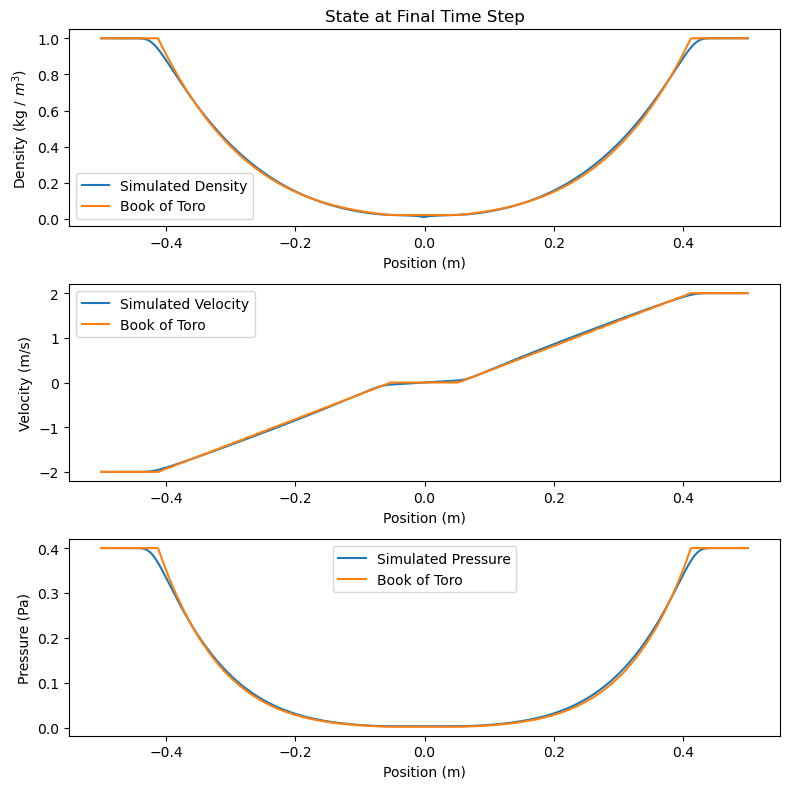

In [8]:
time_index = -1


x_positions = np.linspace(-L4, L1, Nx +2)


plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)  #density
plt.plot(x_positions, rho_history[:, time_index], label='Simulated Density')
plt.plot(toro2.iloc[:,0], toro2.iloc[:,3], label = "Book of Toro")
plt.title('State at Final Time Step')
plt.xlabel('Position (m)')
plt.ylabel('Density (kg / ' + r'$m^3$' + ')')
plt.legend()

plt.subplot(3, 1, 2)  #velocity
plt.plot(x_positions, u_history[:, time_index], label='Simulated Velocity')
plt.plot(toro2.iloc[:,0], toro2.iloc[:,4], label = "Book of Toro")
plt.xlabel('Position (m)')
plt.ylabel('Velocity (m/s)')
plt.legend()

plt.subplot(3, 1, 3)  # pressure
plt.plot(x_positions, p_history[:, time_index], label='Simulated Pressure')
plt.plot(toro2.iloc[:,0], toro2.iloc[:,5], label = "Book of Toro")
plt.xlabel('Position (m)')
plt.ylabel('Pressure (Pa)')
plt.legend()

plt.tight_layout()
plt.show()

## Problem 3

### Q3.1

In [9]:
L1, L4 = 19, 1
p1, T1, u1 = 0.1 * 1e5, 293, 0  #p1 to Pascals
p4, T4, u4 = 100 * 1e5, 293, 0  #p4 to Pascals

Nx = 100
dt = 1e-4
t_final = 0.08
boundary_type = 'solid-wall'

c = 343  
u_max = 4 * c  
dx = (L1 + L4) / Nx
cfl = dt * u_max / dx
print(f"CFL number: {cfl}")  # Should be <= 1 for stability
if cfl > 1:
    print("Warning: CFL condition not satisfied, adjust dt or Nx")

rho3, u3, p3 = solve_shock_tube(L1, L4, gamma, R, p1, T1, u1, p4, T4, u4, Nx, t_final, dt, boundary_type)

CFL number: 0.686


### Q3.2

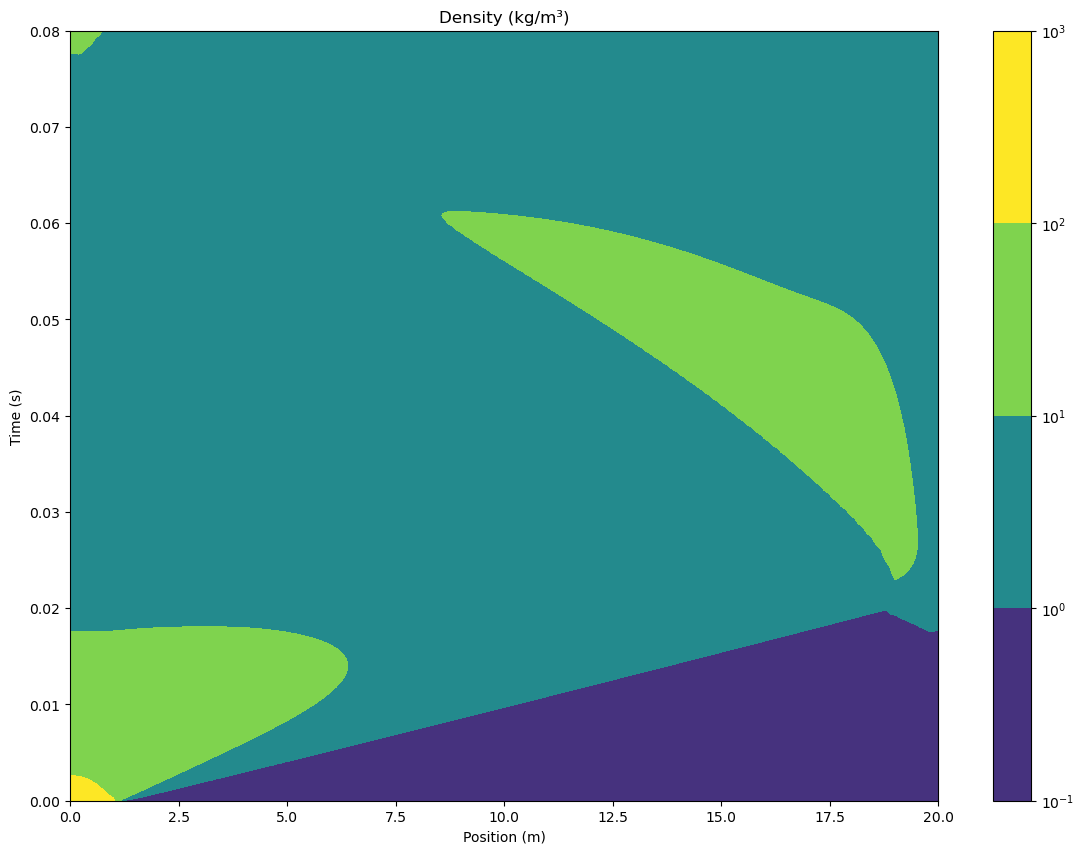

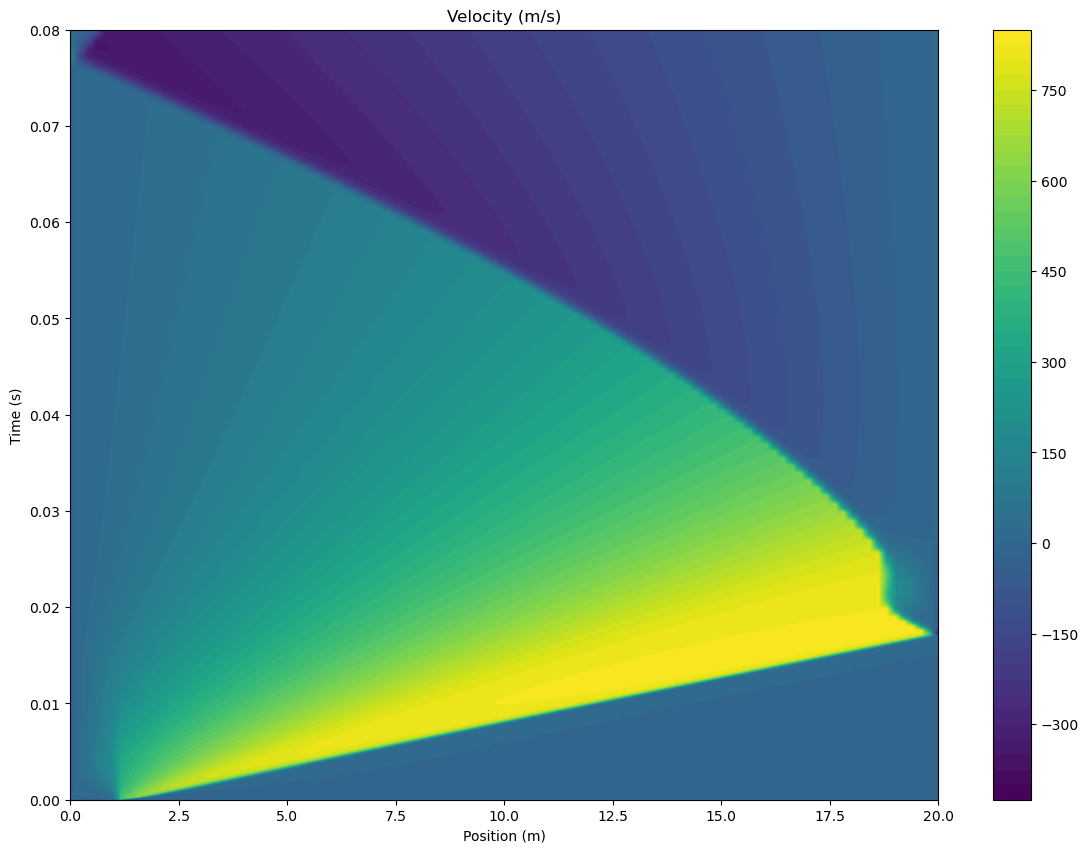

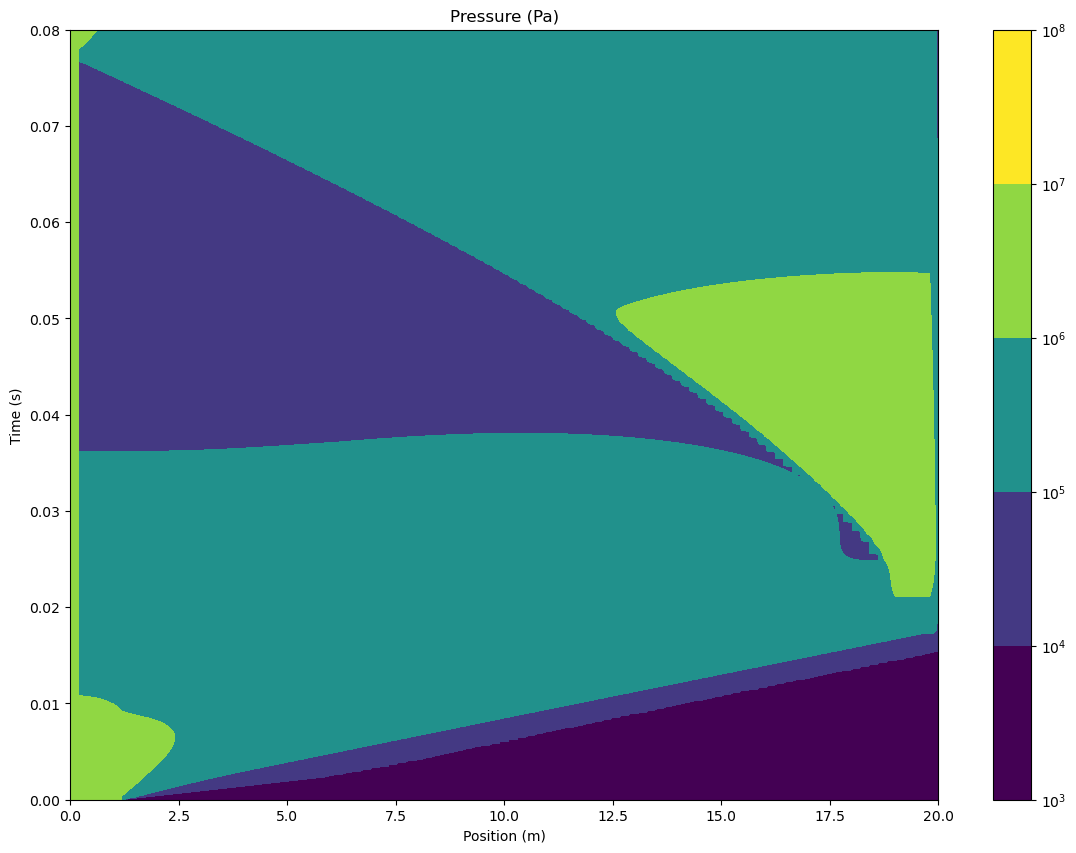

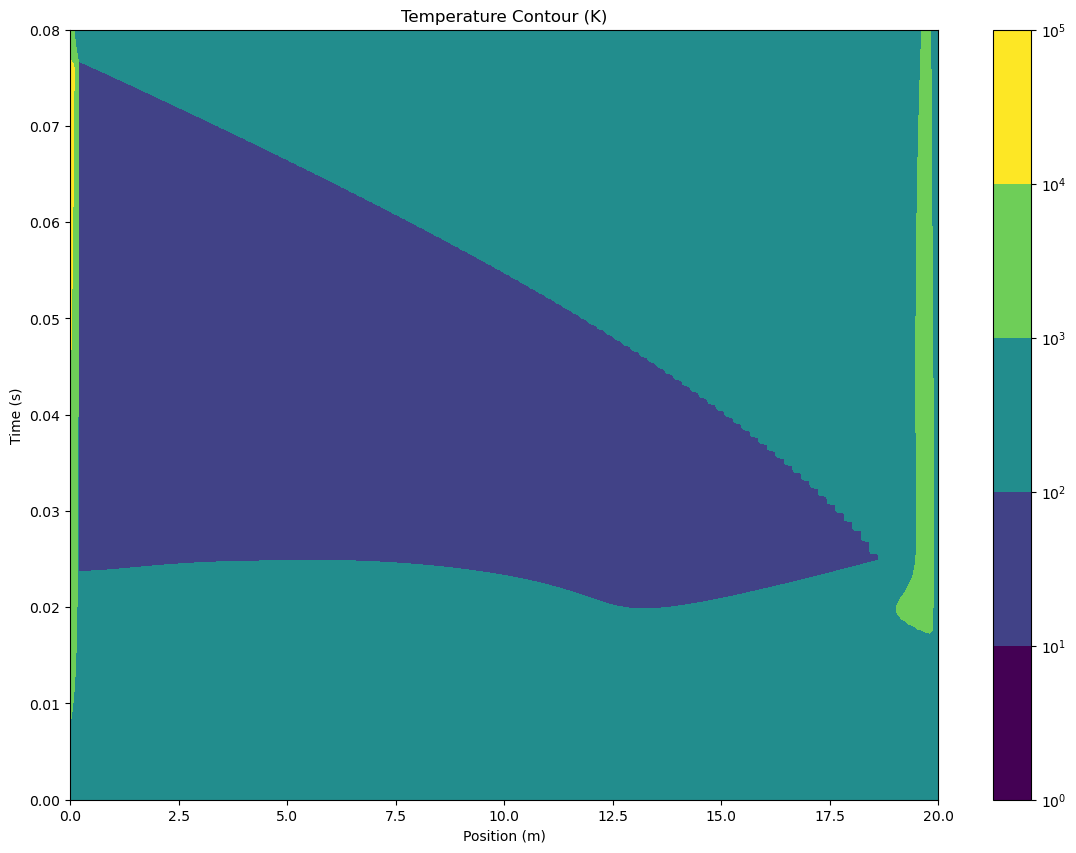

In [10]:
from matplotlib.colors import LogNorm

x = np.linspace(0, L1 + L4, Nx + 2)
t = np.linspace(0, t_final, int(t_final / dt) + 1)
X, T = np.meshgrid(x, t)

def plot_contours(data, title, x_label, y_label, log_scale=False):
    plt.figure(figsize=(14, 10))
    if log_scale:
        # Use logarithmic normalization
        norm = LogNorm(vmin=np.min(data[data > 0]), vmax=np.max(data))
        cp = plt.contourf(X, T, data, levels=50, cmap='viridis', norm=norm)
    else:
        # Regular linear scaling
        cp = plt.contourf(X, T, data, levels=50, cmap='viridis')
        #plt.axhline(y=t[519], color='k', linestyle='-')
    
    plt.colorbar(cp)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
plot_contours(rho3.T, 'Density (kg/m³)', 'Position (m)', 'Time (s)', log_scale=True)
plot_contours(u3.T, 'Velocity (m/s)', 'Position (m)', 'Time (s)')
plot_contours(p3.T, 'Pressure (Pa)', 'Position (m)', 'Time (s)', log_scale=True)

t3 = p3 / (rho3 * R)
plot_contours(t3.T, 'Temperature (K)', 'Position (m)', 'Time (s)', log_scale=True)

The primary shock interacts with the right wall first at the position of the right wall at around $t=0.0173$.

The primary shock then interacts with the contact discontinuity at around $x=18$ and a time of $t=0.02$.

The primary expansion fan reflects off the left wall at at time of around $t=0.766$.

### Q3.3

The equations provided is:

$$ 
\frac{p_4}{p_1} = \frac{2\gamma M_s^2 - (\gamma - 1)}{\gamma + 1}[1 - \frac{\gamma - 1}{\gamma + 1} \frac{c_1}{c_4}(M_s - \frac{1}{M_s})]^{-\frac{2\gamma}{\gamma - 1}}
$$

plugging in the values from above, and use the equation:

$$
c_k = \sqrt{\gamma R T_k}
$$

for the speed of sound, however, as the two starting temperatures are equal, we can ignore the ratio of speed of sounds in the equation.

We get the two solutions of $M_s = -0.128, 3.15$ and because we can't have a negative Mach number, the theoretical mach number is $M_s = 3.15$

To calculate the Mach number of the wave using our data, we can evaluate the system by taking the maximum of the shock for these points, this will give us the speed of the shock. Using the index of the the maximum, we can find the corresponding temperture and use the equation above to find the shock Mach number.

In [110]:
x = 55
print(max(u3[x,:]))
index = np.where(u3[x] == max(u3[x,:]))
speedSoundPoint = np.sqrt(1.4*287 * t3[x,index[0][0]])
Ma = (max(u3[x,:]) + speedSoundPoint) / (np.sqrt(1.4*287*293))
print(Ma)

826.6619575312951
3.410749072832601


This gives us our initial estimate for the shock Mach number as 3.41, which seems to be quite different from our theoretical value

### Q3.4


The CFL condition is given as:
$$
\textbf{CFL} = \frac{|u|\Delta t}{\Delta x} \leq 1
$$

if we want to bring in the Mach number, we can divide both sides by the speed of sound:
$$
\textbf{CFL} = \frac{|u|\Delta t}{\Delta x c} \leq \frac{1}{c}
$$

$$
\textbf{CFL} = \frac{M_s \Delta t}{\Delta x} \leq \frac{1}{c}
$$

$$
M_s \leq \frac{\Delta x}{c \Delta t}
$$

And the substituting $\Delta x = \frac{L_4 + L_1}{N_x}$, we get:
$$
M_s \leq \frac{L_4 + L_1}{c \Delta t N_x}
$$

If we increase our orignal Nx by 40, we decrease $\Delta x$ as $\Delta x$ is $\frac{L_1 + L_4}{N_x}$

In [95]:
L1, L4 = 19, 1
p1, T1, u1 = 0.1 * 1e5, 293, 0  #p1 to Pascals
p4, T4, u4 = 100 * 1e5, 293, 0  #p4 to Pascals

Nx = 140
dt = 1e-4
t_final = 0.08
boundary_type = 'solid-wall'

c = 343  
u_max = 4 * c  
dx = (L1 + L4) / Nx
cfl = dt * u_max / dx
print(f"CFL number: {cfl}")  # Should be <= 1 for stability
if cfl > 1:
    print("Warning: CFL condition not satisfied, adjust dt or Nx")
    
rho32, u32, p32 = solve_shock_tube(L1, L4, gamma, R, p1, T1, u1, p4, T4, u4, Nx, t_final, dt, boundary_type)
t32 = p32 / (rho32 * R)

CFL number: 0.9604000000000001


In [96]:
x = 40
print(max(u32[x,:]))
index = np.where(u32[x] == max(u32[x,:]))
speedSoundPoint = np.sqrt(1.4*287 * t32[x,index[0][0]])
Ma = (max(u32[x,:]) + speedSoundPoint) / (np.sqrt(1.4*287*293))
print(Ma)


825.072369025116
3.3821318366778566


As a result, the shock Mach number has decresed and is now 3.38, which is closer to our theoretical shock Mach number.

Unfortunately, we are unable to increase our $\Delta x$ at the particular $\Delta t$ as it would violate our CFL condition.

We cna now decrease $\Delta t$ to compare with our original solution.

In [98]:
L1, L4 = 19, 1
p1, T1, u1 = 0.1 * 1e5, 293, 0  #p1 to Pascals
p4, T4, u4 = 100 * 1e5, 293, 0  #p4 to Pascals

Nx = 100
dt = 7.5e-5
t_final = 0.08
boundary_type = 'solid-wall'

c = 343  
u_max = 4 * c  
dx = (L1 + L4) / Nx
cfl = dt * u_max / dx
print(f"CFL number: {cfl}")  # Should be <= 1 for stability
if cfl > 1:
    print("Warning: CFL condition not satisfied, adjust dt or Nx")
    
rho33, u33, p33 = solve_shock_tube(L1, L4, gamma, R, p1, T1, u1, p4, T4, u4, Nx, t_final, dt, boundary_type)

CFL number: 0.5145


In [99]:
x = 40
print(max(u33[x,:]))
index = np.where(u33[x] == max(u33[x,:]))
speedSoundPoint = np.sqrt(1.4*287 * t33[x,index[0][0]])
Ma = (max(u33[x,:]) + speedSoundPoint) / (np.sqrt(1.4*287*293))
print(Ma)

815.8648562803944
3.2367399954152933


Our shock Mach number also approaches the theortical Mach number as $\Delta t$ is decreased.

Finally we can decrease both values by a large amount to preserve the CFL condition and evaluate further:

In [100]:
L1, L4 = 19, 1
p1, T1, u1 = 0.1 * 1e5, 293, 0  #p1 to Pascals
p4, T4, u4 = 100 * 1e5, 293, 0  #p4 to Pascals

Nx = 400
dt = 2.5e-5
t_final = 0.08
boundary_type = 'solid-wall'

c = 343  
u_max = 4 * c  
dx = (L1 + L4) / Nx
cfl = dt * u_max / dx
print(f"CFL number: {cfl}")  # Should be <= 1 for stability
if cfl > 1:
    print("Warning: CFL condition not satisfied, adjust dt or Nx")
    
rho34, u34, p34 = solve_shock_tube(L1, L4, gamma, R, p1, T1, u1, p4, T4, u4, Nx, t_final, dt, boundary_type)

CFL number: 0.686


In [102]:
t34 = p34 / (rho34 * R)
x = 40
print(max(u34[x,:]))
index = np.where(u34[x] == max(u34[x,:]))
speedSoundPoint = np.sqrt(1.4*287 * t34[x,index[0][0]])
Ma = (max(u34[x,:]) + speedSoundPoint) / (np.sqrt(1.4*287*293))
print(Ma)

796.6680588424989
3.167779529098117


We can see from above, 3.167 is not so much different from the theoretical value of 3.15,. This displays that as $\Delta t$ and $\Delta x$ are decreased, the estimate of $M_s$ approaches the theoretical value.



### Q3.5

The small model is placed at $L_1 / 2$, which would translate to a $x$-position of 10.5.

using the same plot as before, we can approximate the time where the shock wave first passes the model, then the time where the contact discontinuity impacts the model. The difference in the time is the length of the "test time'


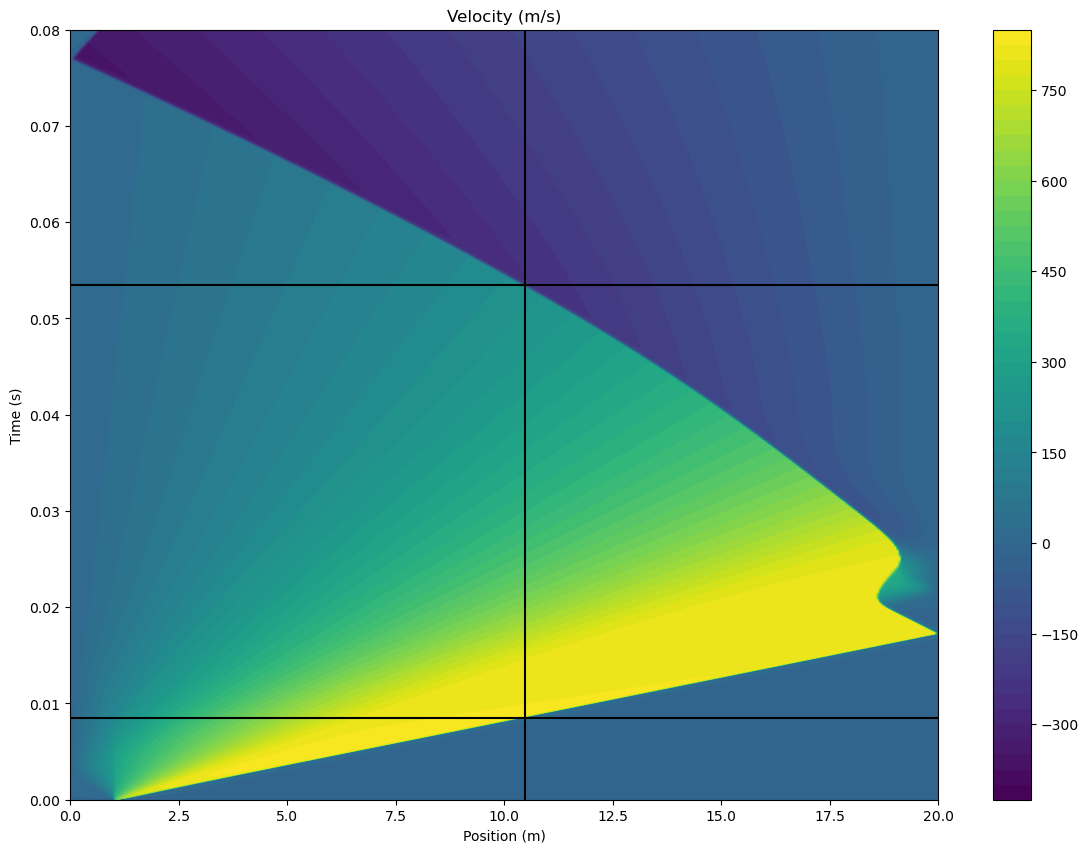

In [109]:
x = np.linspace(0, L1 + L4, Nx + 2)
t = np.linspace(0, t_final, int(t_final / dt) + 1)
X, T = np.meshgrid(x, t)

def plot_contours(data, title, x_label, y_label, log_scale=False):
    plt.figure(figsize=(14, 10))
    if log_scale:
        #logarithmic normalization
        norm = LogNorm(vmin=np.min(data[data > 0]), vmax=np.max(data))
        cp = plt.contourf(X, T, data, levels=50, cmap='viridis', norm=norm)
    else:
        #linear scaling
        cp = plt.contourf(X, T, data, levels=50, cmap='viridis')
        plt.axvline(x=x[210], color='k', linestyle='-')
        plt.axhline(y=t[2140], color='k', linestyle='-')
        plt.axhline(y=t[340], color='k', linestyle='-')
    
    plt.colorbar(cp)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    

plot_contours(u34.T, 'Velocity (m/s)', 'Position (m)', 'Time (s)')

The primary shock first passes the model at the time index of $340$, which mutiplied of our timestep of $2.5e-5$, we get $t = 0.0085$.

The contact discontinuity impacts the model at the time index of $2140$, which mutiplied of our timestep of $2.5e-5$, we get $t = 0.0535$.

The test time would then be:

$\textbf{test time} = 0.0535 - 0.0085 = 0.045$ seconds.